In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def iou_loss(y_true, y_pred):
    return 1 - iou(y_true, y_pred)

In [2]:
from tensorflow.keras.layers import MaxPooling2D, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.models import Model

def conv_block1(inputs, filters):
    x = Conv2D(filters, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def encoder_block1(inputs, filters):
    x = conv_block1(inputs, filters)
    p = MaxPooling2D(pool_size=(2, 2))(x)
    return x, p

def decoder_block1(inputs, filters, concat_layer):
    x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(inputs)
    x = concatenate([x, concat_layer])
    x = conv_block1(x, filters)
    return x

def unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block1(inputs, 32)  # Reduce filters in encoder blocks
    s2, p2 = encoder_block1(p1, 64)
    s3, p3 = encoder_block1(p2, 128)
    s4, p4 = encoder_block1(p3, 256)

    b1 = conv_block1(p4, 512)  # Reduce filters in bottleneck block

    d1 = decoder_block1(b1, 256, s4)  # Reduce filters in decoder blocks
    d2 = decoder_block1(d1, 128, s3)
    d3 = decoder_block1(d2, 64, s2)
    d4 = decoder_block1(d3, 32, s1)

    outputs = Conv2D(1, (1, 1), activation="sigmoid")(d4)

    unet_model = Model(inputs, outputs, name="UNet")
    return unet_model

unet_model = unet((128, 128, 3))
unet_model.summary()

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 128, 128, 32)      │             896 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 128, 128, 32)      │             128 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 128, 128, 32)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 128, 128, 32)      │           9,248 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 128, 128, 32)      │             128 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 128, 128, 32)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 64, 64, 32)        │               0 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 64, 64, 64)        │          18,496 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 64, 64, 64)        │             256 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 64, 64, 64)        │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 64, 64, 64)        │          36,928 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 64, 64, 64)        │             256 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 64, 64, 64)        │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 32, 32, 64)        │               0 │ activation_3[0][0]         │
│ (MaxPooling2D)                │                           │               

 Total params: 7,771,873 (29.65 MB)

 Trainable params: 7,765,985 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [3]:
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import pandas as pd
import os

""" Global parameters """
H = 128
W = 128


def load_dataset(images, masks, split=0.2):

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = cv2.resize(x, (W, H))   ## (h, w)
    x = x / 255.0
    x = x.astype(np.float32)    ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Hyperparameters """
    batch_size = 16
    lr = 1e-4
    num_epochs = 100
    model_path = os.path.join("files", "model.keras")

    """ Dataset """
    df = pd.read_csv("SegData3.csv")[["masks", "data"]]
    input_img_paths = list(df['data'])
    target_img_paths = list(df['masks'])
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(input_img_paths, target_img_paths)


    num_train = 5923
    num_val = 1973
    train_x, train_y = train_x[:num_train], train_y[:num_train]
    valid_x, valid_y = valid_x[:num_val], valid_y[:num_val]
    
    
    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")
    print(f"Test : {len(test_x)} - {len(test_y)}")
    
    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

    """ Model """
    model = unet((H, W, 3))
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef, iou])

    callbacks = [
        ModelCheckpoint(model_path, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False),
    ]

    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        #steps_per_epoch=num_train // batch_size,
        validation_data=valid_dataset,
        #validation_steps=num_val // batch_size,
        callbacks=callbacks,
        verbose=1
    )

Train: 5923 - 5923
Valid: 1973 - 1973
Test : 1973 - 1973
Epoch 1/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 358s 946ms/step - dice_coef: 0.0103 - iou: 0.0052 - loss: 0.9897 - val_dice_coef: 0.0081 - val_iou: 0.0041 - val_loss: 0.9919 - learning_rate: 1.0000e-04
Epoch 2/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 350s 944ms/step - dice_coef: 0.0172 - iou: 0.0087 - loss: 0.9828 - val_dice_coef: 0.0166 - val_iou: 0.0084 - val_loss: 0.9834 - learning_rate: 1.0000e-04
Epoch 3/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 350s 943ms/step - dice_coef: 0.0252 - iou: 0.0129 - loss: 0.9748 - val_dice_coef: 0.0232 - val_iou: 0.0118 - val_loss: 0.9768 - learning_rate: 1.0000e-04
Epoch 4/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 351s 947ms/step - dice_coef: 0.0393 - iou: 0.0203 - loss: 0.9607 - val_dice_coef: 0.0307 - val_iou: 0.0157 - val_loss: 0.9692 - learning_rate: 1.0000e-04
Epoch 5/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 350s 944ms/step - dice_coef: 0.0686 - iou: 0.0362 - loss: 0.9314 - val_dice_coef: 0.0549 - val_iou: 0.0290 - val_loss: 0.9

Epoch 35/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 340s 916ms/step - dice_coef: 0.6074 - iou: 0.4630 - loss: 0.3926 - val_dice_coef: 0.4388 - val_iou: 0.3090 - val_loss: 0.5588 - learning_rate: 1.0000e-06
Epoch 36/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 340s 915ms/step - dice_coef: 0.6078 - iou: 0.4635 - loss: 0.3922 - val_dice_coef: 0.4391 - val_iou: 0.3093 - val_loss: 0.5585 - learning_rate: 1.0000e-06
Epoch 37/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 847ms/step - dice_coef: 0.6082 - iou: 0.4639 - loss: 0.3918
Epoch 37: ReduceLROnPlateau reducing learning rate to 1e-07.
371/371 ━━━━━━━━━━━━━━━━━━━━ 341s 918ms/step - dice_coef: 0.6083 - iou: 0.4639 - loss: 0.3917 - val_dice_coef: 0.4391 - val_iou: 0.3092 - val_loss: 0.5585 - learning_rate: 1.0000e-06


./masks/ID_2a89cc43e.png
./Project/XN_Project/renders/intraparenchymal/intraparenchymal/max_contrast_window/ID_2a89cc43e.jpg None


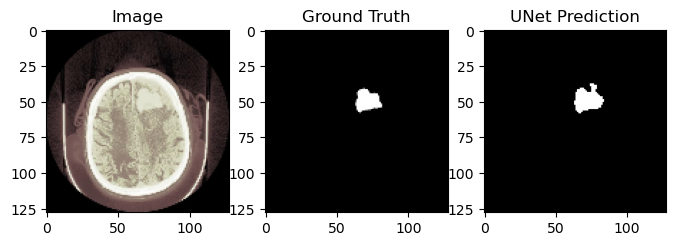

./masks/ID_498d86b25.png
./Project/XN_Project/renders/intraparenchymal/intraparenchymal/max_contrast_window/ID_498d86b25.jpg None


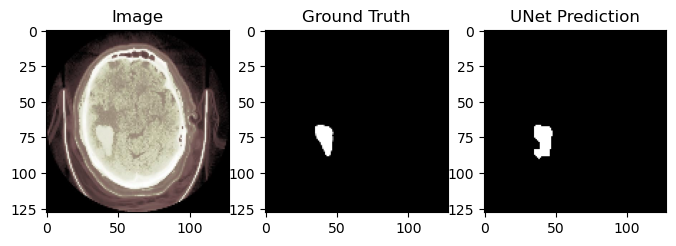

./masks/ID_00f5def87.png
./Project/XN_Project/renders/normal/normal/max_contrast_window/ID_00f5def87.jpg None


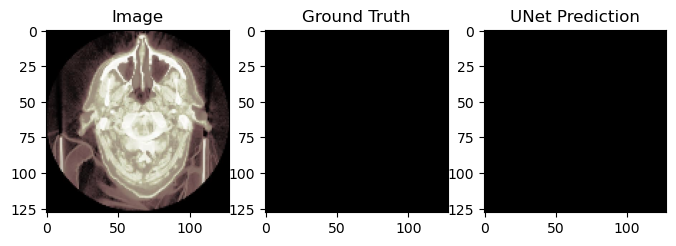

./masks/ID_8a68bfa74.png
./Project/XN_Project/renders/epidural/epidural/max_contrast_window/ID_8a68bfa74.jpg None


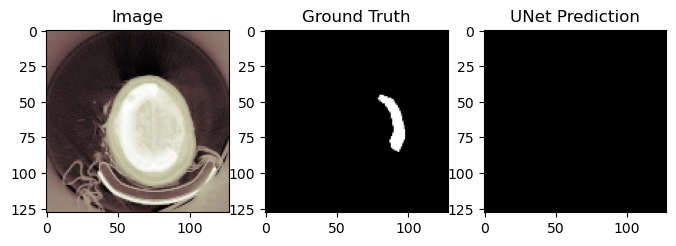

./masks/ID_2d52f5151.png
./Project/XN_Project/renders/intraparenchymal/intraparenchymal/max_contrast_window/ID_2d52f5151.jpg None


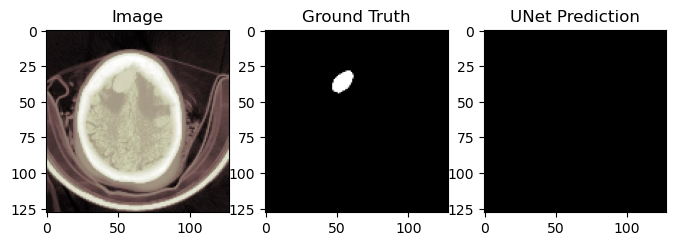

./masks/ID_00205804a.png
./Project/XN_Project/renders/normal/normal/max_contrast_window/ID_00205804a.jpg None


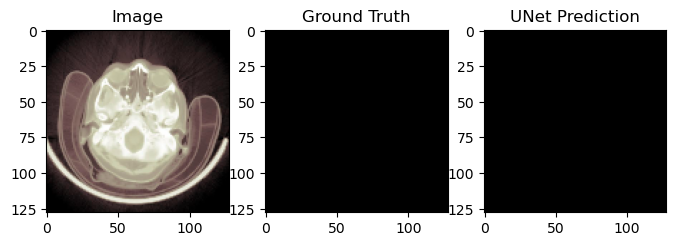

./masks/ID_01ff71eeb.png
./Project/XN_Project/renders/normal/normal/max_contrast_window/ID_01ff71eeb.jpg None


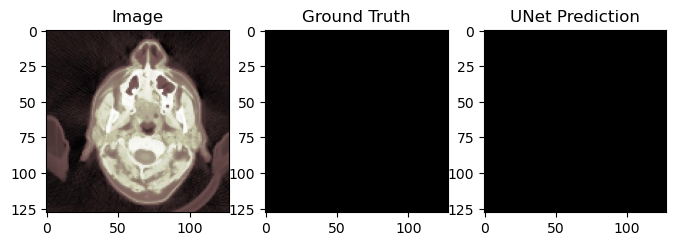

./masks/ID_015535445.png
./Project/XN_Project/renders/normal/normal/max_contrast_window/ID_015535445.jpg None


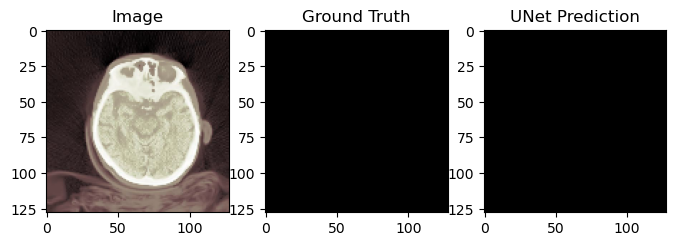

./masks/ID_015b8ae0e.png
./Project/XN_Project/renders/normal/normal/max_contrast_window/ID_015b8ae0e.jpg None


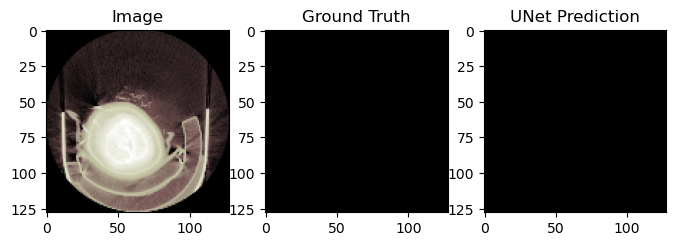

./masks/ID_016549aa5.png
./Project/XN_Project/renders/normal/normal/max_contrast_window/ID_016549aa5.jpg None


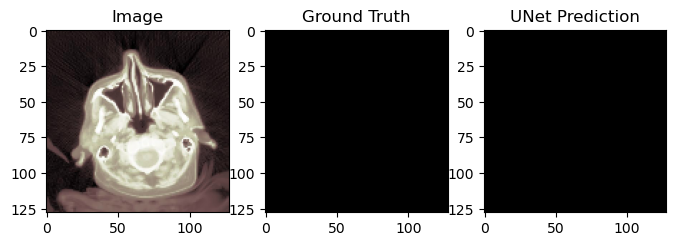

In [6]:
import time
import matplotlib.pyplot as plt

for i in range(10):  
    # Select a random image from the test set
    index = np.random.randint(1, len(test_y))

    # Load the image and preprocess it
    print(test_x[index], print(test_y[index]))
    
    """ Reading the image """
    image = cv2.imread(test_x[index], cv2.IMREAD_COLOR) ## [H, w, 3]
    image = cv2.resize(image, (W, H))       ## [H, w, 3]
    x = image/255.0                         ## [H, w, 3]
    x = np.expand_dims(x, axis=0)           ## [1, H, w, 3]

    """ Reading the mask """
    mask = cv2.imread(test_y[index], cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (W, H))

    """ Prediction """
    y_pred = model.predict(x, verbose=0)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred >= 0.5
    y_pred = y_pred.astype(np.int32)

    # Plot the original image and masks, as well as the predictions
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(image), cmap='gray') 
    plt.title('Image')
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')  
    plt.title('Ground Truth')
    plt.subplot(1, 3, 3)
    plt.imshow(y_pred, cmap='gray')  
    plt.title('UNet Prediction')
    plt.show()
    

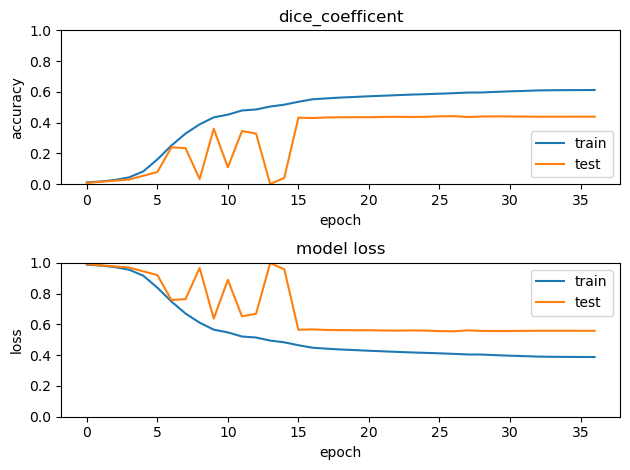

In [7]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('dice_coefficent')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0, 1)
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(0, 1)
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()